In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q timm

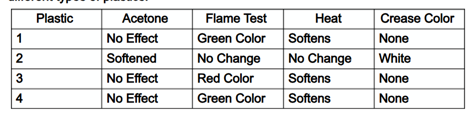

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

file_path = "/content/image.png"
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [ ]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

In [4]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 345, 1333])


In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

In [6]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [8]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

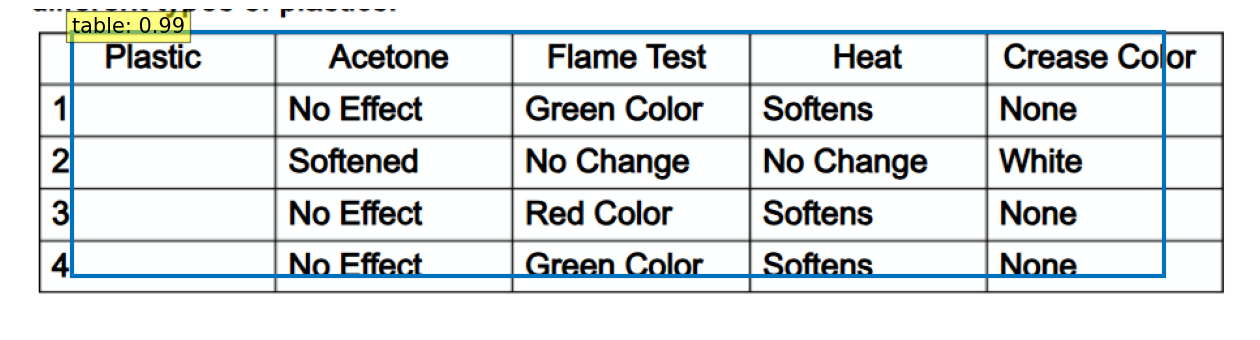

In [9]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

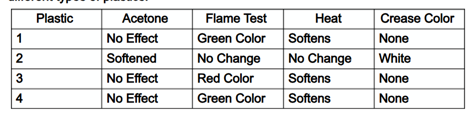

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image
file_path = "/content/image.png"
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [11]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [ ]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

In [13]:
with torch.no_grad():
  outputs = model(**encoding)

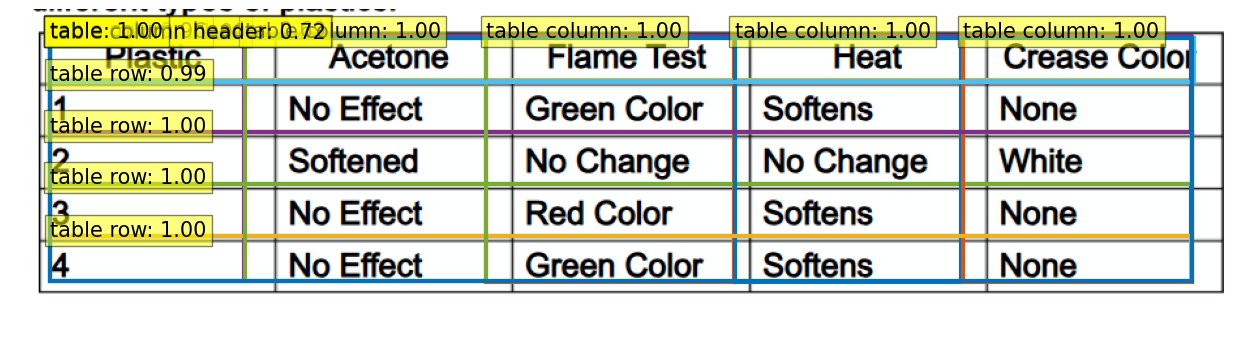

In [14]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [15]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}

In [16]:
import json

# Convert the results to a list of dictionaries for JSON export
json_output = []
id2label = model.config.id2label
# Get all unique labels to check if they are in id2label
unique_labels = results['labels'].unique().tolist()

# Check for mismatch and handle unknown labels
unknown_label_count = 0
for label in unique_labels:
    if label not in id2label:
        id2label[label] = f"unknown_{unknown_label_count}"  # Assign a name to the unknown label
        unknown_label_count += 1
        print(f"Warning: Found unknown label: {label}, assigned as {id2label[label]}")
# Then proceed to use id2label as before
for idx, (score, label, box) in enumerate(zip(results['scores'], results['labels'], results['boxes'])):
    # Convert the label to a standard Python integer if it's a tensor
    label = int(label)
    component = {
        "id": f"{id2label[label]}/{idx}",
        "type": id2label[label],
        "bbox": {
            "xmin": float(box[0]),
            "ymin": float(box[1]),
            "length": float(box[2]-box[0]),
            "breadth": float(box[3]-box[1])
        }
    }
    json_output.append(component)

# Save to a JSON file
with open("table_structure.json", "w") as f:
    json.dump(json_output, f, indent=4)

print("JSON saved to table_structure.json")

JSON saved to table_structure.json


In [19]:
import json

# Load the structure JSON
with open("table_structure.json") as f:
    data = json.load(f)

# Filter rows and columns, excluding specific types
ignored_types = {
    "table column header",
    "table projected row header",
    "table spanning cell",
    "table"
}

rows = [item for item in data if item["type"] == "table row"]
columns = [item for item in data if item["type"] == "table column"]

# Generate intersection cells
cells = []
cell_id = 0

for row in rows:
    for col in columns:
        xmin_cell = max(row["bbox"]["xmin"], col["bbox"]["xmin"])
        ymin_cell = max(row["bbox"]["ymin"], col["bbox"]["ymin"])
        xmax_cell = min(row["bbox"]["xmin"] + row["bbox"]["length"],
                        col["bbox"]["xmin"] + col["bbox"]["length"])
        ymax_cell = min(row["bbox"]["ymin"] + row["bbox"]["breadth"],
                        col["bbox"]["ymin"] + col["bbox"]["breadth"])

        if xmax_cell > xmin_cell and ymax_cell > ymin_cell:
            cell = {
                "id": f"cell/{cell_id}",
                "bbox": {
                    "xmin": xmin_cell,
                    "ymin": ymin_cell,
                    "xmax": xmax_cell,
                    "ymax": ymax_cell,
                    "width": xmax_cell - xmin_cell,
                    "height": ymax_cell - ymin_cell
                },
                "row_id": row["id"],
                "column_id": col["id"]
            }
            cells.append(cell)
            cell_id += 1

# Save the output
with open("table_cells_new.json", "w") as f:
    json.dump(cells, f, indent=4)

print(f"Saved {len(cells)} cells to 'table_cells.json'")


Saved 25 cells to 'table_cells.json'


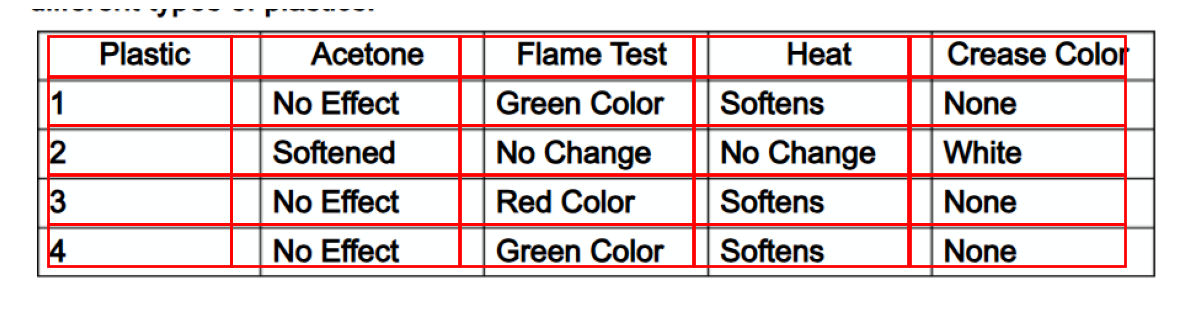

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the image
image_path = "/content/image.png"
image = Image.open(image_path)

# Load the JSON with cell data
json_path = "/content/table_cells_new.json"
with open(json_path, 'r') as f:
    cell_data = json.load(f)

# Prepare the plot
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.imshow(image)
ax.axis('off')

# Draw bounding boxes on the image
for cell in cell_data:
    bbox = cell['bbox']
    x, y = bbox['xmin'], bbox['ymin']
    width, height = bbox['width'], bbox['height']
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)

plt.tight_layout()
plt.show()


